# Bibliotecas e download do dataset

In [1]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout
from keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile
from PIL import Image

In [2]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.17G/5.20G [00:43<00:00, 272MB/s]
100% 5.20G/5.20G [00:43<00:00, 127MB/s]


In [3]:
zip_ref = zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Tratamento do Dataset

In [4]:
df = pd.read_csv('/content/hmnist_28_28_RGB.csv')
y = df['label']
x = df.drop(columns = ['label'])

In [5]:
oversample = RandomOverSampler()# oversampler para remediar o problema da quantidade desigual de nevos no dataset
x, y = oversample.fit_resample(x, y)
y = y.reset_index(drop=True)

In [6]:
x = x.values
y = y.values
x = x.reshape(-1, 28, 28, 3)
x= x.astype('float32') / 255.0

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=42)

X_train = tf.image.resize(X_train, (75, 75))
X_test = tf.image.resize(X_test, (75, 75))

# Definição do modelo

In [7]:

inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inceptionv3.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model = Sequential()
model.add(inceptionv3)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

In [9]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [10]:
checkpoint = ModelCheckpoint(
    filepath = '/content/modelo.keras',
    monitor ='val_sparse_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)
callback = EarlyStopping(monitor = 'val_loss', patience = 4)

In [11]:
hist = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), callbacks=[checkpoint, callback], verbose = 1)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0401 - sparse_categorical_accuracy: 0.6349
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.87845, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 64s 37ms/step - loss: 1.0398 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.3599 - val_sparse_categorical_accuracy: 0.8784
Epoch 2/10
1171/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.8939
Epoch 2: val_sparse_categorical_accuracy improved from 0.87845 to 0.91808, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - loss: 0.3117 - sparse_categorical_accuracy: 0.8940 - val_loss: 0.2394 - val_sparse_categorical_accuracy: 0.9181
Epoch 3/10
1171/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9459
Epoch 3: val_sparse_categorical_accuracy improved from 0.91808 to 0.94002, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━

# Métricas e matriz de confusão

In [12]:

acc_treino= max(hist.history['sparse_categorical_accuracy'])
acc_val = max(hist.history['val_sparse_categorical_accuracy'])

print(f'Acurácia Treino : {acc_treino}')
print(f'Acurácia Validação : {acc_val}')


Acurácia Treino : 0.9813039302825928
Acurácia Validação : 0.9772025346755981


In [13]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='weighted')# weighted por conta do dataset desbalanceado anteriormente
recall = recall_score(Y_test, y_pred, average='weighted')
print(f'Precisão: {precision}')
print(f'Recall: {recall}')
print(f'Acurácia: {accuracy}')

294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step
Precisão: 0.9749902146101603
Recall: 0.975071907957814
Acurácia: 0.975071907957814


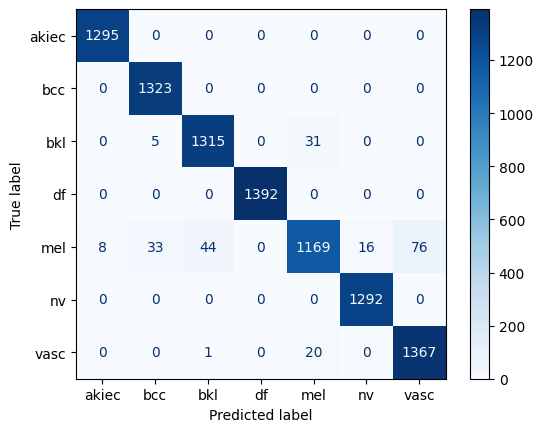

In [14]:

classes = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5:'nv', 6: 'vasc'}
matriz = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes.values())
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


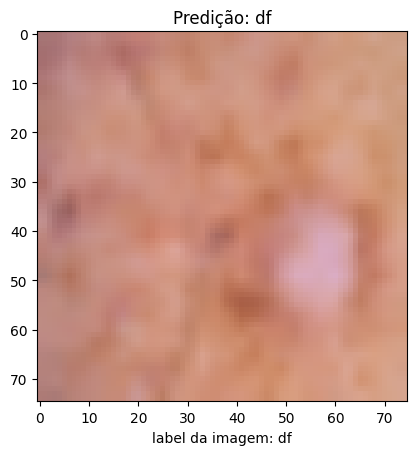

In [15]:
x=43
prev =model.predict(np.expand_dims(X_test[x], axis=0))
predicted_class = tf.argmax(prev, axis=1).numpy()[0]
plt.title(f'Predição: {classes[predicted_class]}')
plt.text(0.5, -0.1,f'label da imagem: {classes[Y_test[x]]}', ha='center', va='center', transform=plt.gca().transAxes)
plt.imshow(X_test[x])# testes em uma imagem do dataset

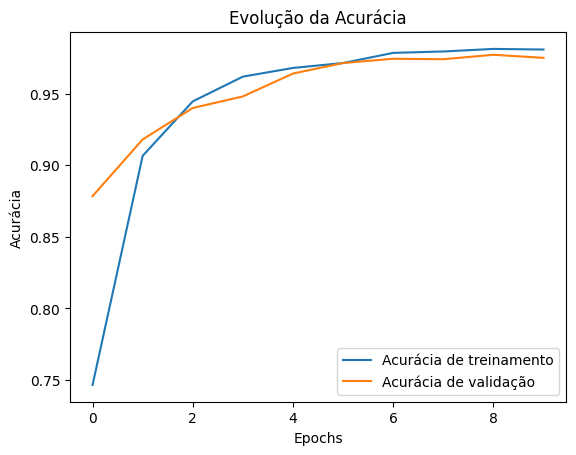

In [20]:
plt.plot(hist.history['sparse_categorical_accuracy'], label='Acurácia de treinamento')
plt.plot(hist.history['val_sparse_categorical_accuracy'], label='Acurácia de validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Testes com imagens obtidas em laboratório

In [26]:
img_dir = '/content/imagens celular/'
img_rosto = []
img_costas = []
img_pai = []
for file_name in os.listdir(img_dir):
    image_path = os.path.join(img_dir, file_name)

    img = Image.open(image_path)
    img = img.resize((75, 75))
    img_array = np.array(img) / 255.0  #
    img_array = img_array.astype('float32')
    if 'Rosto' in file_name:
      img_rosto.append(img_array)
    elif 'costas' in file_name:
      img_costas.append(img_array)
    elif 'pai' in file_name:
      img_pai.append(img_array)# tratamento de imagens fora do dataset

In [27]:
titulo_rosto = []
titulo_costas = []
titulo_pai = []
for img in img_rosto:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_rosto.append(classes[prev_classe])

for img in img_pai:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_pai.append(classes[prev_classe])

for img in img_costas:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_costas.append(classes[prev_classe])
# predição realizada nas imagens fotografadas pelo celular

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Text(0.5, 0.1, 'Predição:akiec')

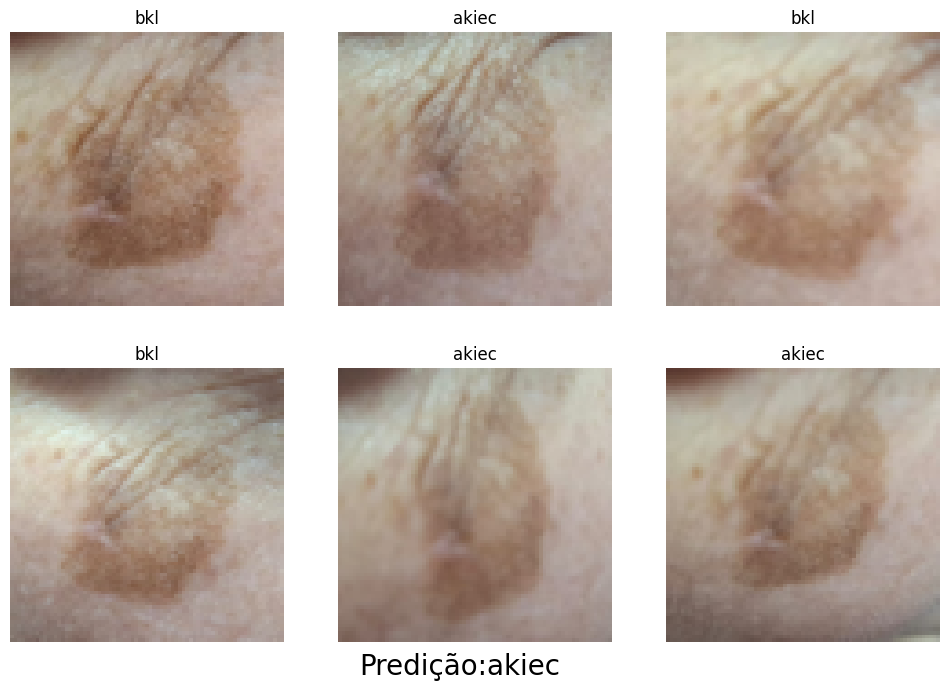

In [28]:
plt.figure(figsize=(12, 8))

for i in range(len(img_rosto)):
    plt.subplot(2, 3, i + 1)  # Organizando as imagens em um grid 2x3
    plt.imshow(img_rosto[i])
    plt.title(titulo_rosto[i])
    plt.axis('off')
moda = max(set(titulo_rosto), key=titulo_rosto.count)
plt.figtext(0.5, 0.1, f'Predição:{moda}', ha='center', va='top', fontsize=20, color='black')

Text(0.5, 0.1, 'Predição:mel')

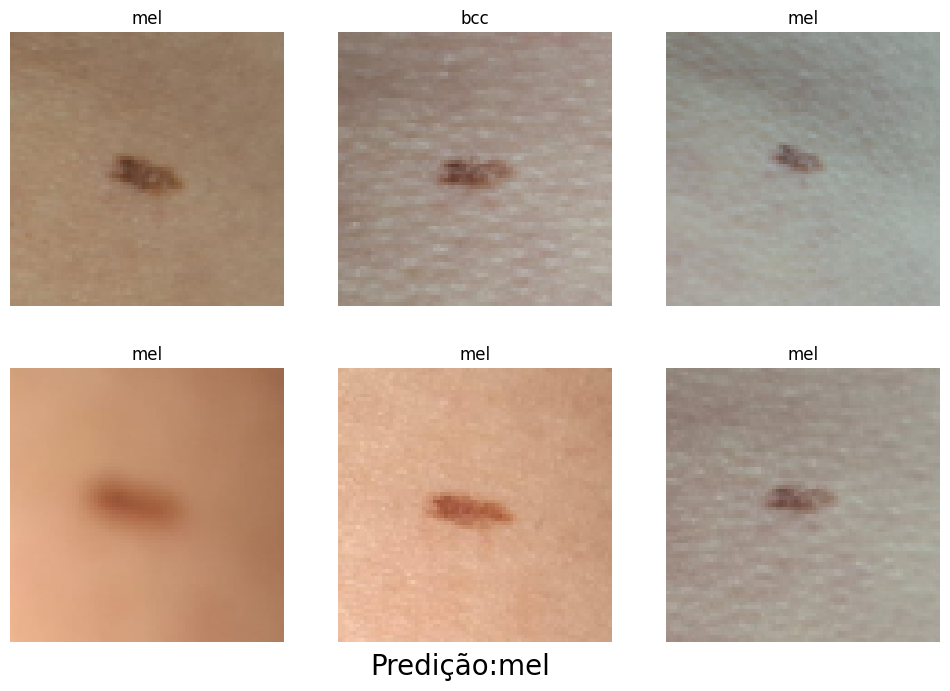

In [29]:
plt.figure(figsize=(12, 8))

for i in range(len(img_costas)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_costas[i])
    plt.title(titulo_costas[i])
    plt.axis('off')
moda = max(set(titulo_costas), key=titulo_costas.count)
plt.figtext(0.5, 0.1, f'Predição:{moda}', ha='center', va='top', fontsize=20, color='black')

Text(0.5, 0.1, 'Predição:mel')

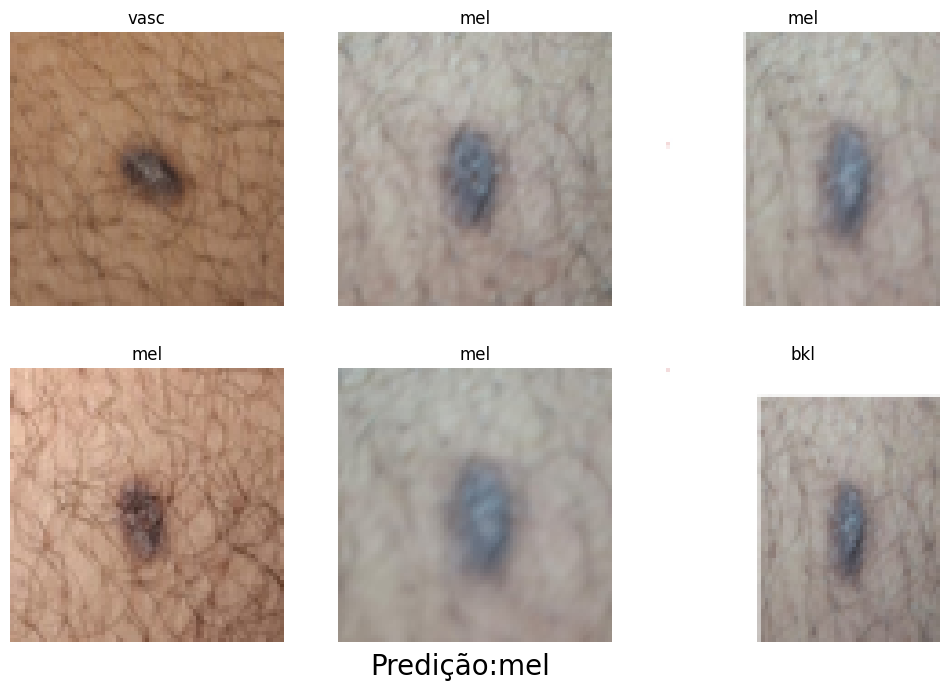

In [30]:
plt.figure(figsize=(12, 8))

for i in range(len(img_pai)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_pai[i])
    plt.title(titulo_pai[i])
    plt.axis('off')

moda = max(set(titulo_pai), key=titulo_pai.count)
plt.figtext(0.5, 0.1, f'Predição:{moda}', ha='center', va='top', fontsize=20, color='black')

In [21]:
img_dir = '/content/imagens laboratorio/'
img_lab = []
for file_name in os.listdir(img_dir):
    image_path = os.path.join(img_dir, file_name)

    img = Image.open(image_path)
    img = img.resize((75, 75))
    img_array = np.array(img) / 255.0  #
    img_array = img_array.astype('float32')

    img_lab.append(img_array)

In [22]:
titulo_lab = []
for img in img_lab:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_lab.append(classes[prev_classe])
# predição realizada nas dermatoscopias obtidas

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


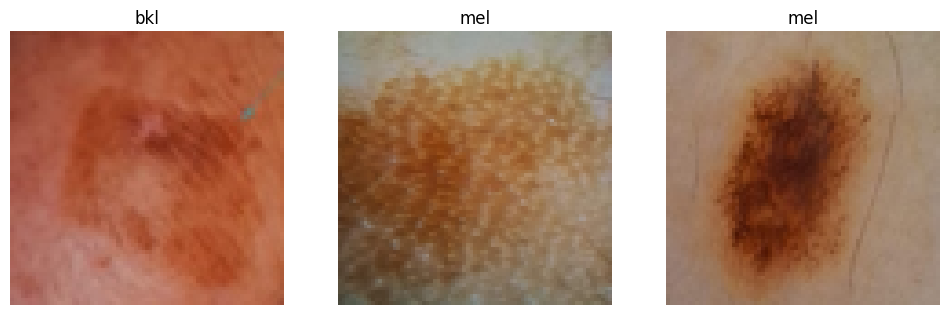

In [23]:
plt.figure(figsize=(12, 8))
for i in range(len(img_lab)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img_lab[i])
    plt.title(titulo_lab[i])
    plt.axis('off')